In [28]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import StandardScaler
import seaborn

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25


data can be download from here: https://www.kaggle.com/dansbecker/starting-your-ml-project/data

In [1]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/ml/melb_data.csv'
melbourne_data = pd.read_csv(f)
melbourne_data.head()

NameError: name 'pd' is not defined

In [4]:
melbourne_data = melbourne_data.dropna(axis=0)

In [5]:
y = melbourne_data.Price

In [6]:
melbourne_predictors = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 
                        'YearBuilt', 'Lattitude', 'Longtitude']

In [7]:
X = melbourne_data[melbourne_predictors]

In [8]:
# Define model
melbourne_model = DecisionTreeRegressor()

# Fit model
melbourne_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [9]:
print("Making predictions for the following 5 houses:")
print(X.head())
print("The predictions are")
print(melbourne_model.predict(X.head()))

Making predictions for the following 5 houses:
   Rooms  Bathroom  Landsize  BuildingArea  YearBuilt  Lattitude  Longtitude
1      2       1.0     156.0          79.0     1900.0   -37.8079    144.9934
2      3       2.0     134.0         150.0     1900.0   -37.8093    144.9944
4      4       1.0     120.0         142.0     2014.0   -37.8072    144.9941
6      3       2.0     245.0         210.0     1910.0   -37.8024    144.9993
7      2       1.0     256.0         107.0     1890.0   -37.8060    144.9954
The predictions are
[ 1035000.  1465000.  1600000.  1876000.  1636000.]


In [17]:
predicted_home_prices = melbourne_model.predict(X)
mean_absolute_error(y, predicted_home_prices)

434.71594577146544

you can not use the prediction for the tranining data to calculate prediction accuracy because the model has seen the data already. so one way is to split the data into traning set and validation set

In [19]:
# split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)
# Define model
melbourne_model = DecisionTreeRegressor()
# Fit model
melbourne_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = melbourne_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

261494.100065


In [20]:
def get_mae(max_leaf_nodes, predictors_train, predictors_val, targ_train, targ_val):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(predictors_train, targ_train)
    preds_val = model.predict(predictors_val)
    mae = mean_absolute_error(targ_val, preds_val)
    return(mae)

In [21]:
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  347380
Max leaf nodes: 50  		 Mean Absolute Error:  257829
Max leaf nodes: 500  		 Mean Absolute Error:  243176
Max leaf nodes: 5000  		 Mean Absolute Error:  254915


In [23]:
forest_model = RandomForestRegressor()
forest_model.fit(train_X, train_y)
melb_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, melb_preds))

204525.34717


In [30]:
# Load data
melb_data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/melb_data.csv')

melb_target = melb_data.Price
melb_predictors = melb_data.drop(['Price'], axis=1)

# For the sake of keeping the example simple, we'll use only numeric predictors. 
melb_numeric_predictors = melb_predictors.select_dtypes(exclude=['object'])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(melb_numeric_predictors, 
                                                    melb_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

In [42]:
def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

In [37]:
X_train.isnull().any()

Rooms           False
Bathroom        False
Landsize        False
BuildingArea    False
YearBuilt       False
Lattitude       False
Longtitude      False
dtype: bool

In [44]:
cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]

In [45]:
cols_with_missing

['Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude',
 'Propertycount']

In [43]:
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)
print("Mean Absolute Error from dropping columns with Missing Values:")
print(score_dataset(reduced_X_train, reduced_X_test, y_train, y_test))

Mean Absolute Error from dropping columns with Missing Values:
349283.430295


In [46]:
my_imputer = Imputer()
imputed_X_train = my_imputer.fit_transform(X_train)
imputed_X_test = my_imputer.transform(X_test)
print("Mean Absolute Error from Imputation:")
print(score_dataset(imputed_X_train, imputed_X_test, y_train, y_test))

Mean Absolute Error from Imputation:
202568.30607


In [110]:
### Get Score from Imputation with Extra Columns Showing What Was Imputed

In [118]:
imputed_X_train_plus = X_train.copy()
imputed_X_test_plus = X_test.copy()

In [119]:
cols_with_missing = (col for col in X_train.columns 
                                 if X_train[col].isnull().any())

In [113]:
# generator becomes empty after iterated
for col in cols_with_missing:
    print(col)

Distance
Postcode
Bedroom2
Bathroom
Car
Landsize
BuildingArea
YearBuilt
Lattitude
Longtitude
Propertycount


In [120]:
imputed_X_train_plus.head(2)

,Unnamed: 0,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
5043,6603,3,8.7,3032.0,3.0,2.0,2.0,210.0,NaN,NaN,-37.7732,144.8790,4918.0
1402,1772,3,11.2,3186.0,3.0,0.0,0.0,0.0,NaN,NaN,-37.9301,144.9935,10579.0


In [121]:
for col in cols_with_missing:
    print(col)
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()

Distance
Postcode
Bedroom2
Bathroom
Car
Landsize
BuildingArea
YearBuilt
Lattitude
Longtitude
Propertycount


In [122]:
imputed_X_train_plus.columns

Index(['Unnamed: 0', 'Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom',
       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude',
       'Longtitude', 'Propertycount', 'Distance_was_missing',
       'Postcode_was_missing', 'Bedroom2_was_missing', 'Bathroom_was_missing',
       'Car_was_missing', 'Landsize_was_missing', 'BuildingArea_was_missing',
       'YearBuilt_was_missing', 'Lattitude_was_missing',
       'Longtitude_was_missing', 'Propertycount_was_missing'],
      dtype='object')

In [125]:
imputed_X_train_plus[imputed_X_train_plus.Landsize_was_missing==True].head(2)

,Unnamed: 0,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Postcode_was_missing,Bedroom2_was_missing,Bathroom_was_missing,Car_was_missing,Landsize_was_missing,BuildingArea_was_missing,YearBuilt_was_missing,Lattitude_was_missing,Longtitude_was_missing,Propertycount_was_missing
13712,17628,2,12.7,3085.0,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,True,True,True,True,True,True,False
10919,14030,3,8.5,3185.0,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,True,True,True,True,True,True,False


In [126]:
# Imputation
my_imputer = Imputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)
imputed_X_test_plus = my_imputer.transform(imputed_X_test_plus)

print("Mean Absolute Error from Imputation while Track What Was Imputed:")
print(score_dataset(imputed_X_train_plus, imputed_X_test_plus, y_train, y_test))

Mean Absolute Error from Imputation while Track What Was Imputed:
200945.345769


In [130]:
imputed_X_train_plus[0,:]

array([  6.60300000e+03,   3.00000000e+00,   8.70000000e+00,
         3.03200000e+03,   3.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.10000000e+02,   1.53541211e+02,
         1.96608654e+03,  -3.77732000e+01,   1.44879000e+02,
         4.91800000e+03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [132]:
# Read the data
import pandas as pd
train_data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/train.csv')
test_data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/test.csv')

# Drop houses where the target is missing
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

target = train_data.SalePrice

In [135]:
train_data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [134]:
target.shape


(1460,)

In [136]:
# Since missing values isn't the focus of this tutorial, we use the simplest
# possible approach, which drops these columns. 
# For more detail (and a better approach) to missing values, see
# https://www.kaggle.com/dansbecker/handling-missing-values
cols_with_missing = [col for col in train_data.columns 
                                 if train_data[col].isnull().any()]         

In [137]:
cols_with_missing

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [138]:
                         
candidate_train_predictors = train_data.drop(['Id', 'SalePrice'] + cols_with_missing, axis=1)
candidate_test_predictors = test_data.drop(['Id'] + cols_with_missing, axis=1)

# "cardinality" means the number of unique values in a column.
# We use it as our only way to select categorical columns here. This is convenient, though
# a little arbitrary.
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].nunique() < 10 and
                                candidate_train_predictors[cname].dtype == "object"]
numeric_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols

In [140]:
my_cols[:5]

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities']

In [143]:
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]

In [146]:
train_predictors.shape

(1460, 57)

In [148]:
test_predictors.shape

(1459, 57)

In [155]:
train_predictors.dtypes.sample(10)

PavedDrive      object
LowQualFinSF     int64
OpenPorchSF      int64
MiscVal          int64
PoolArea         int64
RoofMatl        object
BsmtFinSF2       int64
Condition1      object
HalfBath         int64
BedroomAbvGr     int64
dtype: object

In [158]:
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)

In [162]:
train_predictors.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond',
       'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual',
       'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'MSSubClass',
       'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [161]:
train_predictors.head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,548,0,61,0,0,0,0,0,2,2008
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,1Fam,...,460,298,0,0,0,0,0,0,5,2007


In [160]:
one_hot_encoded_training_predictors.head(2)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0


In [163]:
one_hot_encoded_training_predictors.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=159)

In [159]:
def get_mae(X, y):
    # multiple by -1 to make positive MAE score instead of neg value returned as sklearn convention
    return -1 * cross_val_score(RandomForestRegressor(50), 
                                X, y, 
                                scoring = 'neg_mean_absolute_error').mean()

predictors_without_categoricals = train_predictors.select_dtypes(exclude=['object'])

mae_without_categoricals = get_mae(predictors_without_categoricals, target)

mae_one_hot_encoded = get_mae(one_hot_encoded_training_predictors, target)

print('Mean Absolute Error when Dropping Categoricals: ' + str(int(mae_without_categoricals)))
print('Mean Abslute Error with One-Hot Encoding: ' + str(int(mae_one_hot_encoded)))


Mean Absolute Error when Dropping Categoricals: 18456
Mean Abslute Error with One-Hot Encoding: 18202


In [180]:
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_test_predictors = pd.get_dummies(test_predictors)
# make sure the column orders are the same , scikitlearn is sensitive to ordering of columns
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', 
                                                                    axis=1)

In [170]:
train_predictors.head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,548,0,61,0,0,0,0,0,2,2008
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,1Fam,...,460,298,0,0,0,0,0,0,5,2007


In [171]:
test_predictors.head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,...,730.0,140,0,0,0,120,0,0,6,2010
1,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,312.0,393,36,0,0,0,0,12500,6,2010


In [189]:
assert (final_train.columns == final_test.columns).all()

In [183]:
one_hot_encoded_training_predictors.shape

(1460, 159)

In [184]:
one_hot_encoded_test_predictors.shape

(1459, 148)

In [185]:
final_train.shape

(1460, 159)

In [186]:
final_test.shape

(1459, 159)

XGboost model

In [11]:
data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/train.csv')
# test_data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/test.csv')
data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = data.SalePrice
X = data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])

In [12]:
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [13]:
train_X.shape

(1095, 37)

In [14]:
test_X.shape

(365, 37)

In [15]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [16]:
# make predictions
predictions = my_model.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 17772.1804795


In [17]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
# make predictions
predictions = my_model.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 17740.9548801


In [29]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
# make predictions
predictions = my_model.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 18041.1514127


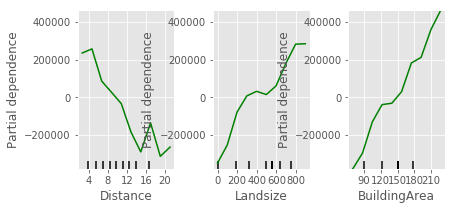

In [56]:
cols_to_use = ['Distance', 'Landsize', 'BuildingArea']

def get_some_data():
    data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/melb_data.csv')
    y = data.Price
    X = data[cols_to_use]
    my_imputer = Imputer()
    imputed_X = my_imputer.fit_transform(X)
    return imputed_X, y
    

X, y = get_some_data()
my_model = GradientBoostingRegressor()
my_model.fit(X, y)
my_plots = plot_partial_dependence(my_model, 
                                   features=[0,1, 2], 
                                   X=X, 
                                   feature_names=cols_to_use, 
                                   grid_resolution=10)

In [64]:
data = pd.read_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/ml/melb_data.csv')
y = data.Price
X = data[cols_to_use]
my_imputer = Imputer()
imputed_X = my_imputer.fit_transform(X)

In [68]:
np.argwhere(np.isnan(imputed_X)) # no nan values in imputed array

array([], shape=(0, 2), dtype=int64)

pipeline

In [4]:
# Read Data
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/ml/melb_data.csv'
data = pd.read_csv(f)
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]
y = data.Price
train_X, test_X, train_y, test_y = train_test_split(X, y)

In [7]:
train_X.shape

(13797, 5)

In [9]:
my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())

In [10]:
my_pipeline.fit(train_X, train_y)
predictions = my_pipeline.predict(test_X)

In [11]:
predictions

array([  934400.        ,  1100650.        ,   895766.66666667, ...,
         536120.45454545,  2067200.        ,   763050.        ])

In [14]:
mean_absolute_error(test_y, predictions)

264416.63593611866

cross validation vs. train_test_split:

    small dataset use cross validation, takes longer to run
    
    large dataset, train_test_split may be sufficient
    
    hold out 20% for validation/test.
    
    5 fold cross validation, hold out each fo the 5 20% of whole data as test data. run 5 times

In [17]:
scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error', cv=5)
print(scores)

[-339121.89529482 -315552.05624208 -312007.34573899 -253540.16659438
 -255377.90996372]


In [24]:
print('Mean Absolute Error {0:.2f}' .format(-1 * scores.mean()))

Mean Absolute Error 295119.87


In [25]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/ml/AER_credit_card_data.csv'

In [26]:
data = pd.read_csv(f, 
                   true_values = ['yes'],
                   false_values = ['no'])
print(data.head())

   card  reports       age  income     share  expenditure  owner  selfemp  \
0  True        0  37.66667  4.5200  0.033270   124.983300   True    False   
1  True        0  33.25000  2.4200  0.005217     9.854167  False    False   
2  True        0  33.66667  4.5000  0.004156    15.000000   True    False   
3  True        0  30.50000  2.5400  0.065214   137.869200  False    False   
4  True        0  32.16667  9.7867  0.067051   546.503300   True    False   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5  


In [27]:
data.shape

(1319, 12)

In [29]:
y = data.card
X = data.drop(['card'], axis=1)

# Since there was no preprocessing, we didn't need a pipeline here. Used anyway as best practice
modeling_pipeline = make_pipeline(RandomForestClassifier())
cv_scores = cross_val_score(modeling_pipeline, X, y, scoring='accuracy')
print("Cross-val accuracy: %f" %cv_scores.mean())

Cross-val accuracy: 0.979528


In [30]:
expenditures_cardholders = data.expenditure[data.card]
expenditures_noncardholders = data.expenditure[~data.card]

print('Fraction of those who received a card with no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))
print('Fraction of those who received a card with no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))

Fraction of those who received a card with no expenditures: 0.02
Fraction of those who received a card with no expenditures: 1.00


In [31]:
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)
cv_scores = cross_val_score(modeling_pipeline, X2, y, scoring='accuracy')
print("Cross-val accuracy: %f" %cv_scores.mean())

Cross-val accuracy: 0.806677
